In [93]:
import osmnx as ox
import networkx as nx
import random
import pandas as pd
import folium
from shapely.geometry import LineString
from folium import Map, PolyLine
import sklearn
import numpy as np


In [5]:
import geopandas as gpd

# Load saved edges GeoDataFrame
edges = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/edges_roads_with_curvature.gpkg", layer='edges')
nodes = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/nodes_roads_with_curvature.gpkg", layer='nodes')

edges.set_index(['u', 'v', 'key'], inplace=True)
nodes.set_index(['osmid'], inplace=True)
# Reconstruct the graph
G = ox.graph_from_gdfs(nodes, edges)
start_lat = 53.1701   # Parsley Hay Car Park lat
start_lon = -1.7816  # Parsley Hay Car Park lon

start_node = ox.nearest_nodes(G, start_lon, start_lat)

<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
C:\Users\khong\AppData\Local\Temp\ipykernel_10632\1545879209.py:4: SyntaxWarning: invalid escape sequence '\k'
  edges = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/edges_roads_with_curvature.gpkg", layer='edges')
C:\Users\khong\AppData\Local\Temp\ipykernel_10632\1545879209.py:5: SyntaxWarning: invalid escape sequence '\k'
  nodes = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/nodes_roads_with_curvature.gpkg", layer='nodes')


In [ ]:
## basic DLS

import networkx as nx

def find_loops_dls(G, start_node, max_distance, min_distance=0, max_depth=20):
    """
    Find looping paths using depth-limited DFS.

    Parameters:
    - G: networkx.MultiDiGraph
    - start_node: node ID to start and end the loop
    - max_distance: maximum cumulative path length
    - min_distance: minimum cumulative path length
    - max_depth: maximum search depth

    Returns:
    - List of valid loops (each as a list of node IDs)
    """
    loops = []

    def dfs(path, total_length, depth):
        current = path[-1]

        if depth > max_depth or total_length > max_distance:
            return

        for _, neighbor, key, data in G.out_edges(current, keys=True, data=True):
            if len(path) > 2 and neighbor == start_node:
                if min_distance <= total_length + data.get("length", 0) <= max_distance:
                    loops.append(path + [neighbor])
                continue

            if neighbor in path:
                continue

            edge_length = data.get("length", 0)
            dfs(path + [neighbor], total_length + edge_length, depth + 1)

    dfs([start_node], 0, 0)
    return loops


In [ ]:
## DLS with no reuse of previously visited roads - takes a very long time :(

def find_loops_dls_no_reuse(G, start_node, max_distance, min_distance=0, max_depth=10):
    loops = []

    def dfs(current_node, path, distance, depth, used_edges):
        if current_node == start_node and len(path) > 1:
            if min_distance <= distance <= max_distance:
                loops.append(list(path))
            return

        if depth >= max_depth:
            return

        for neighbor in G.successors(current_node):
            for key, edge_data in G[current_node][neighbor].items():
                edge = (current_node, neighbor, key)
                if edge in used_edges:
                    continue

                edge_length = edge_data.get("length", 0)
                new_distance = distance + edge_length

                if new_distance > max_distance:
                    continue

                used_edges.add(edge)
                path.append(neighbor)

                dfs(neighbor, path, new_distance, depth + 1, used_edges)

                path.pop()
                used_edges.remove(edge)

    dfs(start_node, [start_node], 0, 0, set())
    return loops


In [82]:
def curvature_weighted_dfs(G, start_node, target_distance=2000, max_depth=20, top_k=2, max_paths=1000):
    stack = [([start_node], 0)]
    completed_paths = []

    while stack and len(completed_paths) < max_paths:
        new_stack = stack
        stack = []
        for option in new_stack:
            path, total_length = option
            current_node = path[-1]

            if total_length >= target_distance or len(path) > max_depth:
                completed_paths.append((path, total_length))
                continue

            candidates = []

            for neighbor in G.successors(current_node):
                if neighbor in path:
                    continue  # avoid node re-use

                for key, data in G[current_node][neighbor].items():
                    length = data.get("length", 0)
                    curvature = data.get("curvature", 0)
                    score = (curvature+0.01) * length
                    candidates.append((score, neighbor, length))

            # Sort and take top-k
            candidates.sort(reverse=True)
            top_choices = candidates[:top_k]

            for _, next_node, edge_length in top_choices:
                new_path = path + [next_node]
                new_total_length = total_length + edge_length
                stack.append((new_path, new_total_length))

    return completed_paths

loops_all = curvature_weighted_dfs(G, start_node, target_distance=15000, max_depth=30, top_k=2, max_paths=4000)
print("Number of loops found:", {len(loops_all)})

Number of loops found: {6213}


In [100]:
def analyze_path_metrics(G, path):
    total_length = 0
    curvatures = []
    speedlims = []
    road_names = set()

    for u, v in zip(path[:-1], path[1:]):
        if G.has_edge(u, v):
            # For MultiDiGraph, get all edges between u and v
            edge_data = G.get_edge_data(u, v)
            if edge_data:
                # Choose edge with maximum curvature * length
                best_key = max(
                    edge_data,
                    key=lambda k: edge_data[k].get('curvature', 0) * edge_data[k].get('length', 0)
                )
                data = edge_data[best_key]

                total_length += data.get("length", 0)
                curvatures.append(data.get("curvature", 0))

                # Get speed limit
                speed_limit = data.get("maxspeed")
                if isinstance(speed_limit, str):
                    try:
                        speedlims.append(int(speed_limit.removesuffix(' mph')))
                    except:
                        speedlims.append(30)
                elif speed_limit is None:
                    speedlims.append(30)

                # Add road name(s) to set (can be list or string)
                name = data.get("name")
                if isinstance(name, list):
                    road_names.update(name)
                elif isinstance(name, str):
                    road_names.add(name)
                elif name is None:
                    road_names.add(data.get("osmid"))
        else:
            print(f"Warning: no edge from {u} to {v}")

    avg_curvature = sum(curvatures) / len(curvatures) if curvatures else 0
    num_unique_roads = len(road_names) / len(path)
    avg_speed = sum(speedlims) / len(speedlims)

    # calculate bearing relative to start point
    node_centroid = (np.average(nodes[nodes.index.isin(path)]['y']), np.average(nodes[nodes.index.isin(path)]['x']))
    bearing = np.atan2((node_centroid[0]-start_lat), (node_centroid[1]-start_lon))

    return {
        "total_length": total_length,
        "avg_curvature": avg_curvature,
        "num_unique_roads": num_unique_roads,
        "avg_speed": avg_speed,
        "bearing": bearing
    }


In [103]:
calcs = []
for idx, path in enumerate([i[0] for i in loops_all]):
    a = analyze_path_metrics(G, path)
    a['path_id'] = idx
    calcs.append(a)


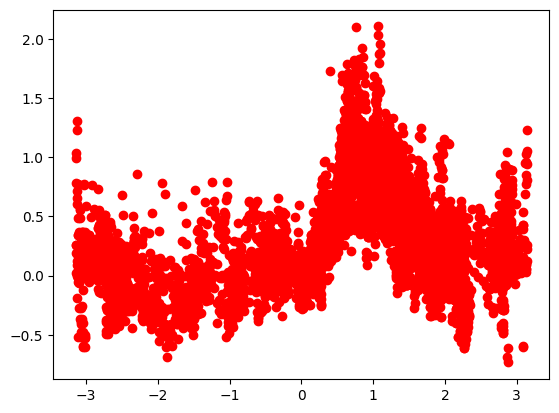

In [107]:
curvature_vector = [i['avg_curvature'] for i in calcs]
roadnumber_vector = [i['num_unique_roads'] for i in calcs]
speed_vector = [i['avg_speed'] for i in calcs]
bearing_vector = [i['bearing'] for i in calcs]

def normalize_vector(vec):
    vec = np.array(vec)
    return (vec - vec.min()) / (vec.max() - vec.min()) if vec.max() > vec.min() else np.zeros_like(vec)

curvature_vector_norm = normalize_vector(curvature_vector)
roadnumber_vector_norm = normalize_vector(roadnumber_vector)
speed_vector_norm = normalize_vector(speed_vector)
score_vector = 2*curvature_vector_norm - roadnumber_vector_norm + speed_vector_norm

plt.plot(bearing_vector, score_vector, 'ro')

results = pd.DataFrame(
    {
        'path_id': [i['path_id'] for i in calcs],
        'avg_curvature': [i['avg_curvature'] for i in calcs],
        'road_uniqueness': [i['num_unique_roads'] for i in calcs],
        'speed': [i['avg_speed'] for i in calcs],
        'bearing': [i['bearing'] for i in calcs],
        'score': score_vector
    }
)


In [ ]:
# basic choice using only scores

best_path_ids = results.sort_values(by=['score'], ascending=False).head(20)
print(best_path_ids)

In [141]:
from scipy.signal import find_peaks
analysis_vec = results.sort_values(by='bearing')['score'].values

peaks_idx, _ = find_peaks(analysis_vec, distance=200)  # tune `distance` for diversity

best_path_ids = results.sort_values(by='bearing').iloc[peaks_idx]


print(results.sort_values(by='bearing').iloc[peaks_idx]['path_id'].values)

[3877  361 2046  177  141   21  208 1267 5997 1699 4573 1695 5817 3025
 5096 1186 4562 4567 4855 5029 5513 5023 5159 3884]


In [142]:
loops = [loops_all[i] for i in best_path_ids['path_id'].values]
# loops = loops_all

import matplotlib.pyplot as plt

# --- Create Folium map ---
m = folium.Map(location=[start_lat, start_lon], zoom_start=11)

# Plot start
folium.Marker([start_lat, start_lon], popup="Start", icon=folium.Icon(color='green')).add_to(m)

def get_color(val, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('viridis')
    rgba = cmap(norm(val))
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

for path in loops:
    path = path[0]

    path_edges = []

    for u, v in zip(path[:-1], path[1:]):
        # Get all parallel edges between u and v (MultiDiGraph may have >1)
        edge = G.get_edge_data(u, v)
        
        if edge:
            # Select the shortest edge (or first) if multiple exist
            edge_data = min(edge.values(), key=lambda d: d.get('length', float('inf')))
            path_edges.append(edge_data)
            curvature = edge_data.get('curvature', 0)

    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]

    # Add edges to the map
    for row in path_edges:
        if isinstance(row['geometry'], list):
            # Skip any weird geometry
            continue
        folium.PolyLine(locations=[(lat, lon) for lon, lat in row['geometry'].coords],
                        color=get_color(row['curvature'], edges['curvature'].min(), edges['curvature'].max()),
                        weight=5).add_to(m)

# # Plot nodes
# for idx, (lat, lon) in enumerate([(data['y'], data['x']) for i, data in nodes[nodes.index.isin([loops[0][0]][0])].iterrows()], start=1):
#     folium.Marker([lat, lon], popup=f"Waypoint {idx}", icon=folium.Icon(color='blue')).add_to(m)

# Show map
m